# 02 — Admin Boundaries for Sundarbans (India & Bangladesh)

This notebook downloads and prepares administrative boundary polygons for India and Bangladesh, clipped to the project bounding box.


## 1. Import libraries and project configuration

We load geospatial libraries and import shared paths and parameters from `ceam_config.py`.



In [8]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box
import contextily as cx
from pathlib import Path
from ceam_config import BBOX, PATHS, CRS_METRIC, CRS_WGS84

**Path and Bounding Box**

### CEAM AOI Bounding Box — Sundarbans Region

The bounding box used for all CEAM analyses is based on published geographic extents of the **Sundarbans mangrove delta**, which spans southern Bangladesh and eastern India.  
According to multiple sources — including the *Bangladesh Forest Department* and research summaries such as *Giri et al. (2015), Remote Sensing of Environment, 167, 201–214* — the Sundarbans extends approximately between **21°30′–22°40′ N** and **88°05′–89°55′ E**.

Adopting these limits, the CEAM bounding box is fixed as:

```python
bbox = {
    "lon_min": 88.08,
    "lat_min": 21.50,
    "lon_max": 89.92,
    "lat_max": 22.67,
}


## 2. Define project bounding box

All geometries are handled initially in **EPSG:4326 (WGS84)**, which stores coordinates in latitude and longitude (degrees).  
This CRS (Coordinate Reference System) is appropriate for defining geographic extents such as the Sundarbans bounding box.

The bounding box defines the Area of Interest (AOI) for all CEAM analyses and ensures consistent spatial clipping across datasets.

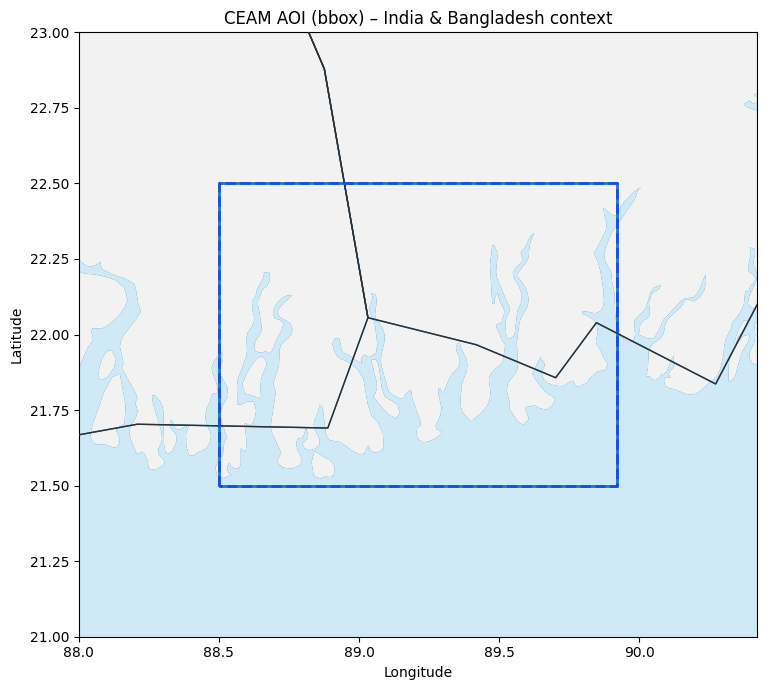

In [3]:
# Get Paths

COUNTRIES_SHP = PATHS["countries_shp"]
LAND_SHP = PATHS["land_shp"]

countries = gpd.read_file(COUNTRIES_SHP).to_crs("EPSG:4326")
land = gpd.read_file(LAND_SHP).to_crs("EPSG:4326")

region = countries[countries["NAME"].isin(["India", "Bangladesh"])]

bbox = BBOX # from config

bbox_gdf = gpd.GeoDataFrame(
    geometry=[box(bbox["lon_min"], bbox["lat_min"], bbox["lon_max"], bbox["lat_max"])],
    crs="EPSG:4326",
)

pad_lon, pad_lat = 0.5, 0.5
xlim = (bbox["lon_min"] - pad_lon, bbox["lon_max"] + pad_lon)
ylim = (bbox["lat_min"] - pad_lat, bbox["lat_max"] + pad_lat)

fig, ax = plt.subplots(figsize=(10, 7))
land.plot(ax=ax, linewidth=0)
region.boundary.plot(ax=ax, linewidth=1)
bbox_gdf.boundary.plot(ax=ax, linewidth=2)

ax.set_title("CEAM AOI (bbox) – India & Bangladesh context")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_facecolor("#CFE9F6")  # water (very light blue)

# Land (Natural Earth 10m land)
land.plot(
    ax=ax,
    facecolor="#F2F2F2",   # land (very light gray)
    edgecolor="none",
    zorder=1
)

# Country borders (India/Bangladesh context)
region.boundary.plot(
    ax=ax,
    color="#2F2F2F",       # dark gray
    linewidth=1.0,
    zorder=3
)

# Your AOI bbox
bbox_gdf.boundary.plot(
    ax=ax,
    color="#1D4ED8",       # blue
    linewidth=2.0,
    linestyle="--",
    zorder=4
)

plt.tight_layout()
plt.show()


## 3. Create OSM context map (EPSG:3857) and Save Hero Figure

To overlay OpenStreetMap (OSM) tiles, geometries must be projected to **EPSG:3857 (Web Mercator)**.  
Web Mercator uses meters as units and is the standard projection used by most web mapping services.

We therefore reproject the administrative boundaries and bounding box from EPSG:4326 to EPSG:3857 before adding the basemap.

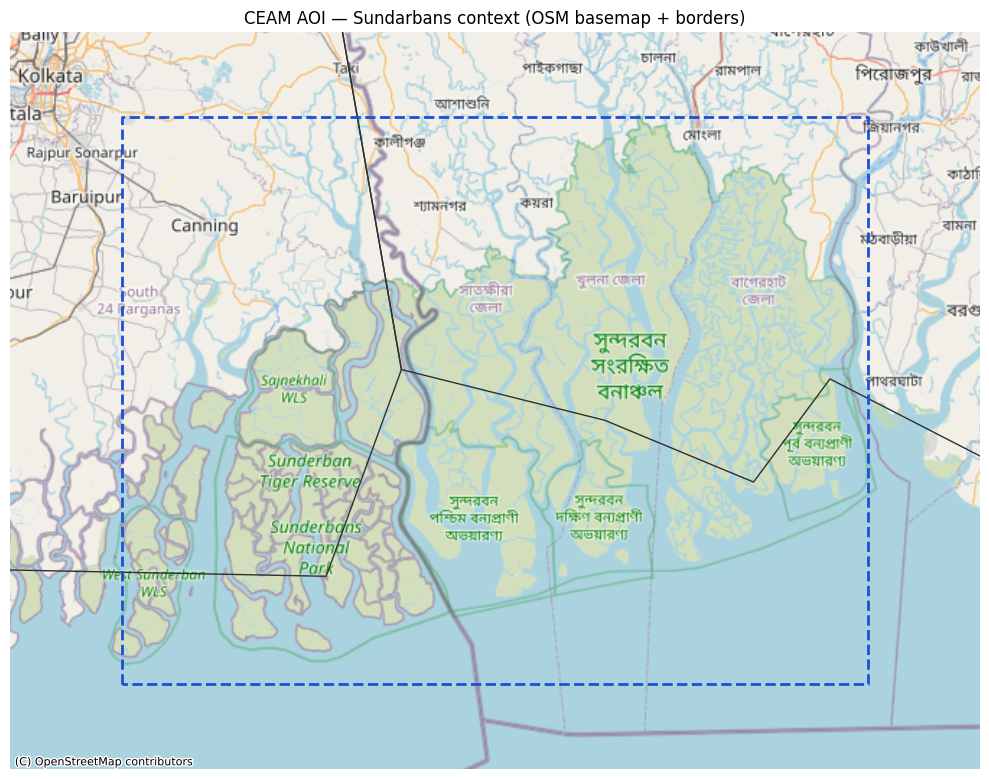

In [9]:
# Project to Web Mercator for basemap tiles
region_3857 = region.to_crs(epsg=3857)
bbox_3857 = bbox_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 8))

# 1) Set extent FIRST (in EPSG:3857)
xmin, ymin, xmax, ymax = bbox_3857.total_bounds
pad_x = (xmax - xmin) * 0.15
pad_y = (ymax - ymin) * 0.15
ax.set_xlim(xmin - pad_x, xmax + pad_x)
ax.set_ylim(ymin - pad_y, ymax + pad_y)

# 2) Now draw basemap for THIS extent
import contextily as cx
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom=9)

# 3) Overlays on top
region_3857.boundary.plot(ax=ax, color="#2F2F2F", linewidth=1.0, zorder=3)
bbox_3857.boundary.plot(ax=ax, color="#1D4ED8", linewidth=2.0, linestyle="--", zorder=4)
ax.set_title("CEAM AOI — Sundarbans context (OSM basemap + borders)")
ax.set_axis_off()
plt.tight_layout()

# Ensure output directory exists
Path(PATHS["hero_png"]).parent.mkdir(parents=True, exist_ok=True)

# Save figure
plt.savefig(PATHS["hero_png"], dpi=300, bbox_inches="tight")

# Show plot
plt.show()


## 4. Export projected boundary layers

The reprojected administrative boundaries and AOI bounding box (EPSG:3857) are saved as GeoJSON files for reuse in later CEAM stages.

GeoJSON preserves geometry and CRS metadata and allows consistent downstream spatial integration.

In [10]:
from pathlib import Path

admin_dir = Path(PATHS["admin_dir"])
admin_dir.mkdir(parents=True, exist_ok=True)

region_3857.to_file(admin_dir / "countries_3857.geojson", driver="GeoJSON")
bbox_3857.to_file(admin_dir / "bbox_3857.geojson", driver="GeoJSON")

region_3857.to_file(out_dir / "countries_3857.geojson", driver="GeoJSON")
bbox_3857.to_file(out_dir / "bbox_3857.geojson", driver="GeoJSON")